In [1]:
import numpy as np
import os
import tensorflow as tf
import keras
import setup_mnist
import denoise_model
from matplotlib import pyplot as plt
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, BasicIterativeMethod

Using TensorFlow backend.


### Data preprocessing (MNIST)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
image_size = x_train.shape[1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

### MNIST model loading

In [3]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
input_shape = (28, 28, 1)

model = setup_mnist.mnist_model(input_shape)
model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])

model_path = "model/model.h5"
model.load_weights(model_path)

#### Model accuracy

In [4]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on total test data: {:4.2f}%'.format(accuracy_test * 100))

10000/10000 [==============================] - 2s 173us/step
Accuracy on total test data: 99.43%


In [5]:
x_test_atk = x_test[0:100]
y_test_atk = y_test[0:100]

#### Model test accuracy

In [6]:
loss_test, accuracy_test = model.evaluate(x_test_atk, y_test_atk)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 249us/step
Accuracy on test data: 99.00%


In [7]:
def plt_show(gray):
    plt.figure()
    plt.imshow(gray[:,:,0], cmap='gray')
    plt.axis('off')
    plt.show()

Original test image


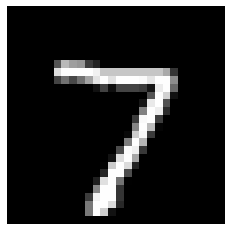

In [8]:
test_index = 0
print('Original test image')
plt_show(x_test_atk[test_index])

In [9]:
classifier = KerasClassifier(model=model, use_logits=True, clip_values=(0, 1))

### Attack test on FGSM

In [10]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv_fgsm = attack_fgsm.generate(x_test_atk)

In [11]:
loss_test, accuracy_test = model.evaluate(x_test_adv_fgsm, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_fgsm - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 94us/step
Accuracy on adversarial test data: 68.00%
Average perturbation: 0.10


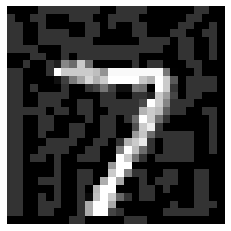

In [12]:
plt_show(x_test_adv_fgsm[test_index])

### Attack test on C&W Method

In [13]:
attack_cw = CarliniLInfMethod(classifier=classifier, eps=0.2, max_iter=100, learning_rate=0.01)
x_test_adv_cw = attack_cw.generate(x_test_atk)

C&W L_inf: 100%|██████████| 1/1 [00:16<00:00, 16.60s/it]


In [14]:
loss_test, accuracy_test = model.evaluate(x_test_adv_cw, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_cw - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 123us/step
Accuracy on adversarial test data: 64.00%
Average perturbation: 0.01


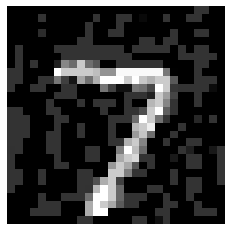

In [15]:
plt_show(x_test_adv_cw[test_index])

### Attack test on PGD (BIM) Method

In [16]:
attack_pgd = BasicIterativeMethod(estimator=classifier, eps=0.2, eps_step=0.05, max_iter=100)
x_test_adv_pgd = attack_pgd.generate(x_test_atk)

In [17]:
loss_test, accuracy_test = model.evaluate(x_test_adv_pgd, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_pgd - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 114us/step
Accuracy on adversarial test data: 1.00%
Average perturbation: 0.10


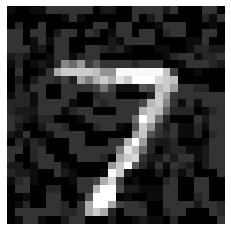

In [18]:
plt_show(x_test_adv_pgd[test_index])

### Denoiser test (before training validation model [just adding denoiser])

In [19]:
dae_path = 'model/DAE.h5'
dm_gaussian_blur_path = 'model/dm_gaussian_blur.h5'
dm_median_blur_path = 'model/dm_median_blur.h5'
dm_dae_path = 'model/dm_dae.h5'

dm_gaussian_blur = denoise_model.DM_GAUSSIAN_BLUR()
dm_median_blur = denoise_model.DM_MEDIAN_BLUR()
dm_nl_means = denoise_model.DM_NL_MEANS()
dm_dae = denoise_model.DM_DAE()

In [20]:
dm_dae.denoiser.compile(loss='mse', optimizer='adam')

dm_gaussian_blur.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_median_blur.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_nl_means.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])

dm_gaussian_blur.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_median_blur.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_nl_means.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])

dm_dae.denoiser.load_weights(dae_path)

dm_gaussian_blur.model.load_weights(model_path)
dm_median_blur.model.load_weights(model_path)
dm_nl_means.model.load_weights(model_path)
dm_dae.model.load_weights(model_path)

#### Original image accuracy

In [21]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 565us/step
Accuracy [Gaussian Blur] on test data: 99.00%


In [22]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 890us/step
Accuracy [Median Blur] on test data: 99.00%


In [23]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 1s 11ms/step
Accuracy [Non-Local Means] on test data: 99.00%


In [24]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 1ms/step
Accuracy [DAE] on test data: 98.00%


#### FGSM accuracy

In [25]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 199us/step
Accuracy [Gaussian Blur] on test data: 83.00%


In [26]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 583us/step
Accuracy [Median Blur] on test data: 77.00%


In [27]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 1s 10ms/step
Accuracy [Non-Local Means] on test data: 69.00%


In [28]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 141us/step
Accuracy [DAE] on test data: 96.00%


#### C&W accuracy

In [29]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 199us/step
Accuracy [Gaussian Blur] on test data: 98.00%


In [30]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 589us/step
Accuracy [Median Blur] on test data: 99.00%


In [31]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 1s 9ms/step
Accuracy [Non-Local Means] on test data: 69.00%


In [32]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 146us/step
Accuracy [DAE] on test data: 98.00%


#### PGD accuracy

In [33]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 204us/step
Accuracy [Gaussian Blur] on test data: 43.00%


In [34]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 589us/step
Accuracy [Median Blur] on test data: 17.00%


In [35]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 1s 10ms/step
Accuracy [Non-Local Means] on test data: 1.00%


In [36]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 152us/step
Accuracy [DAE] on test data: 93.00%


### Denoiser test after training validation model

In [37]:
dm_gaussian_blur.denoise_model.load_weights(dm_gaussian_blur_path)
dm_median_blur.denoise_model.load_weights(dm_median_blur_path)
dm_dae.denoise_model.load_weights(dm_dae_path)

#### Original image accuracy

In [38]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 173us/step
Accuracy [Gaussian Blur] on test data: 100.00%


In [39]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 560us/step
Accuracy [Median Blur] on test data: 100.00%


In [40]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 155us/step
Accuracy [DAE] on test data: 98.00%


#### FGSM accuracy

In [41]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 215us/step
Accuracy [Gaussian Blur] on test data: 91.00%


In [42]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 537us/step
Accuracy [Median Blur] on test data: 80.00%


In [43]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_adv_fgsm, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 172us/step
Accuracy [DAE] on test data: 95.00%


#### C&W accuracy

In [44]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 230us/step
Accuracy [Gaussian Blur] on test data: 100.00%


In [45]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 650us/step
Accuracy [Median Blur] on test data: 100.00%


In [46]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_adv_cw, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 182us/step
Accuracy [DAE] on test data: 97.00%


#### PGD accuracy

In [47]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 226us/step
Accuracy [Gaussian Blur] on test data: 49.00%


In [48]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 599us/step
Accuracy [Median Blur] on test data: 21.00%


In [49]:
loss_test, accuracy_test = dm_dae.denoise_model.evaluate(x_test_adv_pgd, y_test_atk)
print('Accuracy [DAE] on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 178us/step
Accuracy [DAE] on test data: 93.00%


### Denoiser test

#### FGSM

In [50]:
gaussian_blur_fgsm = dm_gaussian_blur.denoiser.predict(x_test_adv_fgsm)
median_blur_fgsm = dm_median_blur.denoiser.predict(x_test_adv_fgsm)
nl_means_fgsm = dm_nl_means.denoiser.predict(x_test_adv_fgsm)
dae_fgsm = dm_dae.denoiser.predict(x_test_adv_fgsm)

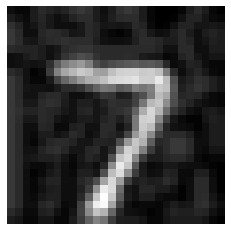

In [51]:
plt_show(gaussian_blur_fgsm[test_index])

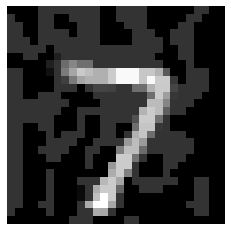

In [52]:
plt_show(median_blur_fgsm[test_index])

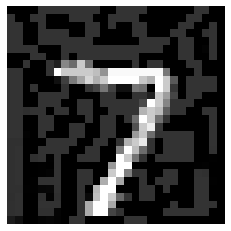

In [53]:
plt_show(nl_means_fgsm[test_index])

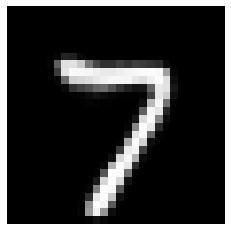

In [54]:
plt_show(dae_fgsm[test_index])

#### C&W

In [55]:
gaussian_blur_cw = dm_gaussian_blur.denoiser.predict(x_test_adv_cw)
median_blur_cw = dm_median_blur.denoiser.predict(x_test_adv_cw)
nl_means_cw = dm_nl_means.denoiser.predict(x_test_adv_cw)
dae_cw = dm_dae.denoiser.predict(x_test_adv_cw)

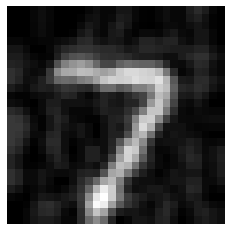

In [56]:
plt_show(gaussian_blur_cw[test_index])

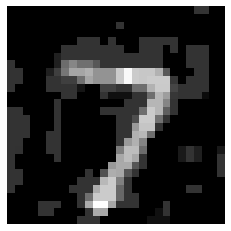

In [57]:
plt_show(median_blur_cw[test_index])

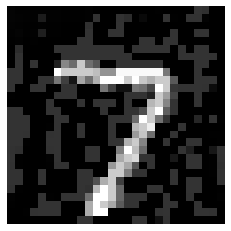

In [58]:
plt_show(nl_means_cw[test_index])

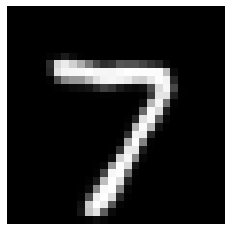

In [59]:
plt_show(dae_cw[test_index])

#### PGD

In [60]:
gaussian_blur_pgd = dm_gaussian_blur.denoiser.predict(x_test_adv_pgd)
median_blur_pgd = dm_median_blur.denoiser.predict(x_test_adv_pgd)
nl_means_pgd = dm_nl_means.denoiser.predict(x_test_adv_pgd)
dae_pgd = dm_dae.denoiser.predict(x_test_adv_pgd)

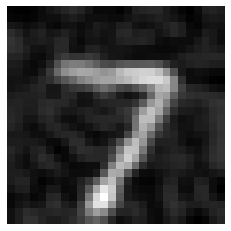

In [61]:
plt_show(gaussian_blur_pgd[test_index])

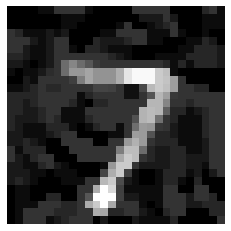

In [62]:
plt_show(median_blur_pgd[test_index])

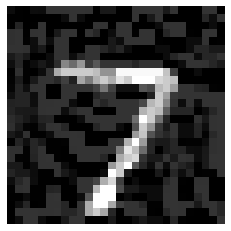

In [63]:
plt_show(nl_means_pgd[test_index])

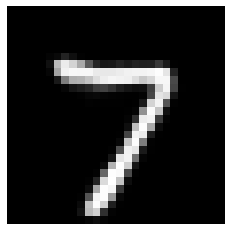

In [64]:
plt_show(dae_pgd[test_index])